In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
import os
print(os.listdir("../input"))
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
import pywt 
from statsmodels.robust import mad
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
rows = 150_000
periods=50000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')
from tsfresh.feature_extraction import feature_calculators
def calc_change_rate(x):
    change = np.diff(x) / x[:-1]
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)
def periodic_apply(x,period,func,*args):
    seg=int(np.floor(len(x)/period))
    result=[]
    for seg_id in range(seg):
        sg=x[seg_id*period:seg_id*period+period]
        result.append(func(sg,*args))
    return result
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    x = pd.Series(seg['acoustic_data'].values)
    xc=denoise_signal(xc.values)
    
    
    X.loc[seg_id,'min_roll_std']=x.rolling(50).std().dropna().values.min()
    X.loc[seg_id,'c3']=feature_calculators.c3(xc, 1000)
    X.loc[seg_id,'limit']=np.where((xc>3.5)&(xc<5),1,0).sum()/150000
    X.loc[seg_id,'limit_last']=np.where((xc[-5000:]>3.5)&(xc[-5000:]<5),1,0).sum()/5000
    #    X.loc[seg_id,'limit_first']=np.where((xc[:5000]>3.5)&(xc[:5000]<5),1,0).sum()/5000

    #    X.loc[seg_id,'number_peak_60']=feature_calculators.number_peaks(xc,60)
    #    X.loc[seg_id,'number_peak_50']=feature_calculators.number_peaks(xc,50)
    X.loc[seg_id,'mode_otn']=x.mode()[0]/x.mean()
    X.loc[seg_id,'mode_median_mean_otn']=X.loc[seg_id,'mode_otn']/(x.mode()[0]/x.median())

    #    X.loc[seg_id,'number_peak_10']=feature_calculators.number_peaks(xc,10)
    X.loc[seg_id,'number_peak_otnBIG_50']=feature_calculators.number_peaks(xc[:50000],50)/feature_calculators.number_peaks(xc[-50000:],50)
    #    X.loc[seg_id,'number_peak_otnBIG']=feature_calculators.number_peaks(xc[:50000],20)/feature_calculators.number_peaks(xc[-50000:],20)
    X.loc[seg_id,'number_peak_otnMIDDLE']=feature_calculators.number_peaks(xc[50000:100000],20)/(feature_calculators.number_peaks(xc[-50000:],20)+feature_calculators.number_peaks(xc[:50000],20))
    #    X.loc[seg_id,'number_crossing_20']=feature_calculators.number_crossing_m(xc, 20)
    try:
        X.loc[seg_id,'number_crossing_otnMIDDLE']=feature_calculators.number_crossing_m(xc[50000:100000],20)/(feature_calculators.number_crossing_m(xc[-50000:],20)+feature_calculators.number_crossing_m(xc[:50000],20))
    except ZeroDivisionError:
        X.loc[seg_id,'number_crossing_otnMIDDLE']=feature_calculators.number_crossing_m(xc[50000:100000],20)/1
    X.loc[seg_id,'big_entropy']=feature_calculators.binned_entropy(xc, 99)
    X.loc[seg_id,'autocorrelation']=feature_calculators.autocorrelation(xc, 5)

    X.loc[seg_id,'std_roll_percentile']=np.percentile(x.rolling(1000).std().dropna().values, 20)
    X.loc[seg_id,'std_roll_percentile_5']=np.percentile(x.rolling(1000).std().dropna().values, 5)
    X.loc[seg_id,'change_rate_otn']=calc_change_rate(xc[:500])/calc_change_rate(xc[-500:])
    #    X.loc[seg_id,'change_rate_otnLITTLE']=calc_change_rate(xc[:5000])/calc_change_rate(xc[-5000:])
    X.loc[seg_id,'number_peak/change_rate']=feature_calculators.number_peaks(xc,10)/calc_change_rate(xc)
    X.loc[seg_id,'number_peak/number_crossing']=feature_calculators.number_peaks(xc,10)/feature_calculators.number_crossing_m(xc, 20)
    X.loc[seg_id,'classic_sta_lta']=classic_sta_lta(xc, 1000, 10000).mean()
    X.loc[seg_id,'time_rev_asym']=feature_calculators.time_reversal_asymmetry_statistic(xc, 10)
    X.loc[seg_id,'argmax']=np.argmax(xc)
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
#    X.loc[seg_id, 'min'] = xc.min()
#    X.loc[seg_id, 'abs_max']=np.abs(xc).max()
#    X.loc[seg_id,'mean_change_rate_last50000']=np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    
    
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)        
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_X.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

from sklearn.preprocessing import StandardScaler    
# scaler = StandardScaler()
# y=train_X['time_to_failure'].values
# train_X=train_X.drop(['time_to_failure'],axis=1)
# scaler.fit(train_X)
# train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
#train_X['time_to_failure']=y
#train_X.to_csv('train_data.csv')

In [4]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.drop(['time_to_failure'],axis=1).columns, dtype=np.float64, index=submission.index)
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)
#test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)
test_X.to_csv('test_data.csv')

In [5]:
from sklearn.model_selection import StratifiedKFold
class target_encoding():
    def __init__(self,df,name,number_percentile=10):
        self.df=df
        self.column=name
        self.number_percentile=number_percentile
    def fit(self):
        self.perc=np.percentile(a=self.df[self.column].values,q=[int((x)*(100/self.number_percentile)) for x in range(self.number_percentile)])
        self.perc[0]=-999999
        self.perc[self.number_percentile-1]=999999
        self.df[self.column]=pd.qcut(self.df[self.column],self.number_percentile, duplicates='drop',labels=False)
        rscf=StratifiedKFold(4,shuffle=True,random_state=100)
        for i,(train_index,val_index) in enumerate(rscf.split(self.df,self.df[self.column])):
            if i==0:
                a=self.df.groupby(self.column)['time_to_failure'].mean()/4
            else:
                a+=self.df.groupby(self.column)['time_to_failure'].mean()/4
        self.a=a.to_dict()
        return self.a,self.perc
    def transform(self,df):
        df[self.column]=pd.cut(df[self.column],self.perc, duplicates='drop',labels=False)
        df[self.column].replace(self.a,inplace =True)
        return df
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
param = {'objective': 'regression_l2', 
    'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 18, 
            'n_estimators': 6100, 
            'subsample_freq': 2, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 20, 
            'min_child_weight': 9.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 36, 
            'reg_alpha': 40.0, 
            'reg_lambda': 13.3, 
            'subsample': 0.9}
num_folds=5
rskf=KFold(num_folds,shuffle=True,random_state=42)
val_pr=np.zeros(len(train_X))
test_pr=np.zeros(len(test_X))
feature_importance_df = pd.DataFrame()
train_columns=[name for name in train_X.columns if name not in ['time_to_failure','outlier']]
#train_X['outlier']=0
#train_X.loc[train_X['time_to_failure']<1,'outlier']
for train_index,val_index in rskf.split(train_X):
#     targ=target_encoding(train_X.loc[train_index],'number_peak_60')
#     targ.fit()
#     train_data=targ.transform(train_X[train_columns].loc[train_index])
#     val_data=targ.transform(train_X[train_columns].loc[val_index])
    train_data=train_X[train_columns].loc[train_index]
    val_data=train_X[train_columns].loc[val_index]
    train_data=lgb.Dataset(train_data,train_X['time_to_failure'].loc[train_index])
    val_data=lgb.Dataset(val_data,train_X['time_to_failure'].loc[val_index])
    num_round=10000
    model=lgb.train(param,train_data,num_round,valid_sets=[train_data,val_data],verbose_eval=100,early_stopping_rounds=400)
    fold_importance_df=pd.DataFrame()
    fold_importance_df['feature']=train_columns
    fold_importance_df['importance']=model.feature_importance()
    feature_importance_df=pd.concat([feature_importance_df,fold_importance_df],axis=0)
    val_pr[val_index]=model.predict(train_X[train_columns].loc[val_index],num_iteration=model.best_iteration)
    test_pr+=model.predict(test_X[train_columns],num_iteration=model.best_iteration)/num_folds
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(train_X['time_to_failure'].values,val_pr))

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 400 rounds.
[100]	training's l1: 2.43769	valid_1's l1: 2.47804
[200]	training's l1: 2.18688	valid_1's l1: 2.27199
[300]	training's l1: 2.06108	valid_1's l1: 2.18309
[400]	training's l1: 1.98564	valid_1's l1: 2.13366
[500]	training's l1: 1.93348	valid_1's l1: 2.10455
[600]	training's l1: 1.89249	valid_1's l1: 2.08842
[700]	training's l1: 1.85665	valid_1's l1: 2.07907
[800]	training's l1: 1.82386	valid_1's l1: 2.07515
[900]	training's l1: 1.79354	valid_1's l1: 2.0716
[1000]	training's l1: 1.76571	valid_1's l1: 2.06909
[1100]	training's l1: 1.74024	valid_1's l1: 2.0678
[1200]	training's l1: 1.71574	valid_1's l1: 2.06736
[1300]	training's l1: 1.69264	valid_1's l1: 2.06613
[1400]	training's l1: 1.67	valid_1's l1: 2.06509
[1500]	training's l1: 1.64818	valid_1's l1: 2.06542
[1600]	training's l1: 1.62758	valid_1's l1: 2.06483
[1700]	training's l1: 1.60728	valid_1's l1: 2.06482
[1800]	training's l1: 1.5882	valid_1's l1: 2.06492
[1900]	training'

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 400 rounds.
[100]	training's l1: 2.43731	valid_1's l1: 2.47348
[200]	training's l1: 2.18287	valid_1's l1: 2.27443
[300]	training's l1: 2.05397	valid_1's l1: 2.18507
[400]	training's l1: 1.97765	valid_1's l1: 2.14381
[500]	training's l1: 1.92557	valid_1's l1: 2.12475
[600]	training's l1: 1.88377	valid_1's l1: 2.11468
[700]	training's l1: 1.84793	valid_1's l1: 2.10922
[800]	training's l1: 1.81503	valid_1's l1: 2.10501
[900]	training's l1: 1.78494	valid_1's l1: 2.10295
[1000]	training's l1: 1.75702	valid_1's l1: 2.10295
[1100]	training's l1: 1.73099	valid_1's l1: 2.10224
[1200]	training's l1: 1.70666	valid_1's l1: 2.10221
[1300]	training's l1: 1.6837	valid_1's l1: 2.10381
[1400]	training's l1: 1.66104	valid_1's l1: 2.10393
Early stopping, best iteration is:
[1049]	training's l1: 1.74403	valid_1's l1: 2.10177


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 400 rounds.
[100]	training's l1: 2.43394	valid_1's l1: 2.52879
[200]	training's l1: 2.18663	valid_1's l1: 2.28772
[300]	training's l1: 2.06293	valid_1's l1: 2.17516
[400]	training's l1: 1.98705	valid_1's l1: 2.12629
[500]	training's l1: 1.93293	valid_1's l1: 2.09936
[600]	training's l1: 1.88915	valid_1's l1: 2.089
[700]	training's l1: 1.85229	valid_1's l1: 2.08389
[800]	training's l1: 1.81817	valid_1's l1: 2.08024
[900]	training's l1: 1.78779	valid_1's l1: 2.07957
[1000]	training's l1: 1.75916	valid_1's l1: 2.07989
[1100]	training's l1: 1.73307	valid_1's l1: 2.07971
[1200]	training's l1: 1.70873	valid_1's l1: 2.08047
Early stopping, best iteration is:
[873]	training's l1: 1.79561	valid_1's l1: 2.07907


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 400 rounds.
[100]	training's l1: 2.46549	valid_1's l1: 2.34092
[200]	training's l1: 2.21279	valid_1's l1: 2.12909
[300]	training's l1: 2.08389	valid_1's l1: 2.04083
[400]	training's l1: 2.00529	valid_1's l1: 2.00656
[500]	training's l1: 1.9499	valid_1's l1: 1.99297
[600]	training's l1: 1.90592	valid_1's l1: 1.98938
[700]	training's l1: 1.86815	valid_1's l1: 1.98771
[800]	training's l1: 1.83538	valid_1's l1: 1.98832
[900]	training's l1: 1.80496	valid_1's l1: 1.98864
[1000]	training's l1: 1.77656	valid_1's l1: 1.98945
[1100]	training's l1: 1.7506	valid_1's l1: 1.99063
Early stopping, best iteration is:
[703]	training's l1: 1.8672	valid_1's l1: 1.98757


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 400 rounds.
[100]	training's l1: 2.42201	valid_1's l1: 2.50992
[200]	training's l1: 2.17616	valid_1's l1: 2.27302
[300]	training's l1: 2.05078	valid_1's l1: 2.17223
[400]	training's l1: 1.97764	valid_1's l1: 2.1255
[500]	training's l1: 1.9257	valid_1's l1: 2.10426
[600]	training's l1: 1.88465	valid_1's l1: 2.09365
[700]	training's l1: 1.8495	valid_1's l1: 2.089
[800]	training's l1: 1.81809	valid_1's l1: 2.08627
[900]	training's l1: 1.7898	valid_1's l1: 2.08487
[1000]	training's l1: 1.76259	valid_1's l1: 2.08331
[1100]	training's l1: 1.73714	valid_1's l1: 2.08288
[1200]	training's l1: 1.71296	valid_1's l1: 2.08208
[1300]	training's l1: 1.69001	valid_1's l1: 2.08088
[1400]	training's l1: 1.66819	valid_1's l1: 2.08096
[1500]	training's l1: 1.64669	valid_1's l1: 2.08122
[1600]	training's l1: 1.62642	valid_1's l1: 2.08133
[1700]	training's l1: 1.60682	valid_1's l1: 2.08166
Early stopping, best iteration is:
[1307]	training's l1: 1.68832	val

In [6]:
submission.time_to_failure=test_pr
submission.to_csv('submission.csv')

In [7]:
print(mean_absolute_error(train_X['time_to_failure'].values,val_pr))

2.0626214549236273


In [8]:
fold_importance_df.sort_values('importance',ascending=False)

,feature,importance
11,std_roll_percentile,2726
1,c3,2573
13,change_rate_otn,2554
12,std_roll_percentile_5,2057
5,mode_median_mean_otn,2031
16,classic_sta_lta,2029
0,min_roll_std,1989
19,max_to_min,1983
6,number_peak_otnBIG_50,1963
17,time_rev_asym,1943


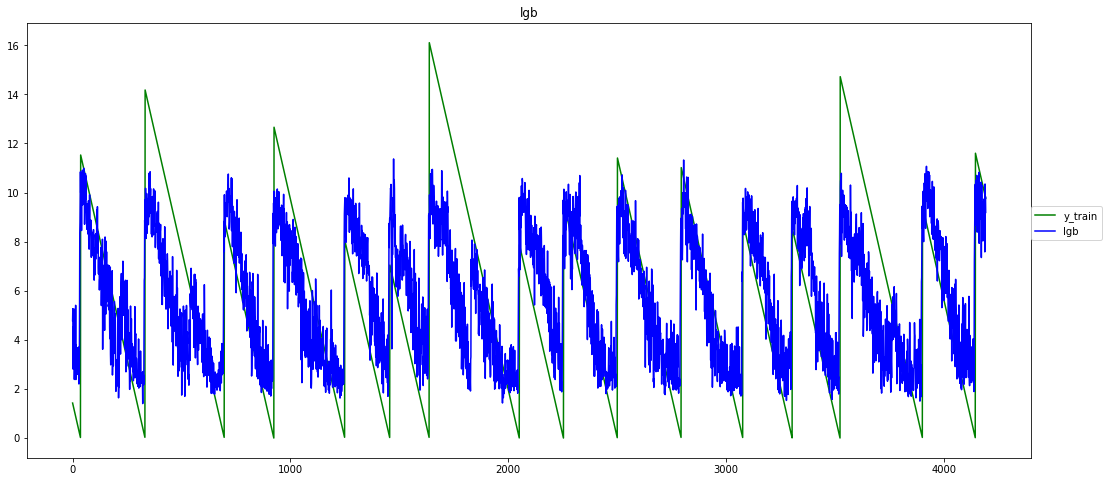

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(18, 8))
plt.plot(train_X['time_to_failure'], color='g', label='y_train')
plt.plot(val_pr, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');

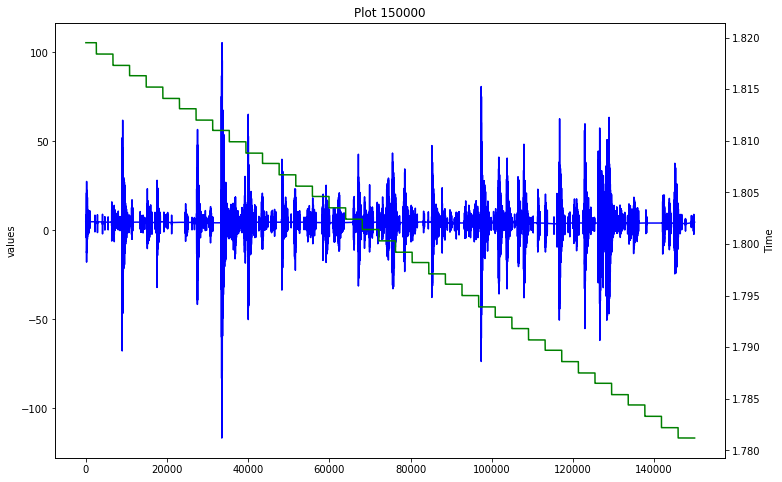

In [10]:
i=1411
import matplotlib.pyplot as plt
%matplotlib inline
_,ax1=plt.subplots(figsize=(12, 8))
plt.plot(denoise_signal(train['acoustic_data'].loc[150000*i:150000*(i+1)]),color='b')
ax1.set_ylabel('values')
ax2=ax1.twinx()
plt.plot(denoise_signal(train['time_to_failure'].loc[150000*i:150000*(i+1)]),color='g')
ax2.set_ylabel('Time')
plt.title('Plot 150000')
plt.show()

KeyError: 'mode_otn_last_begin'

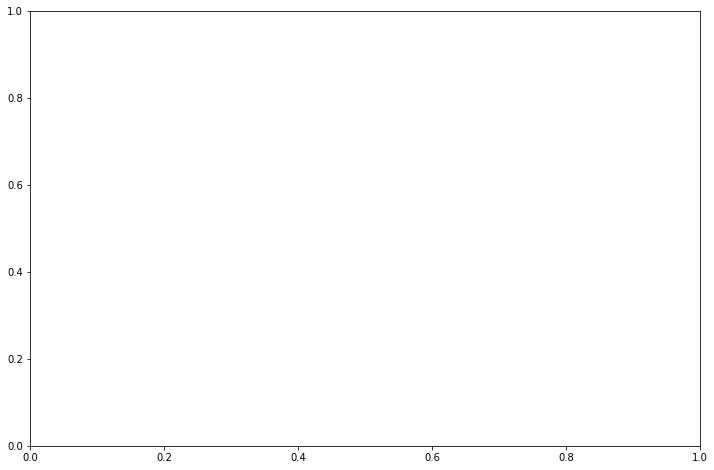

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
_,ax1=plt.subplots(figsize=(12,8))
plt.plot(train_X['mode_otn_last_begin'], color='g', label='y_train')
ax1.set_ylabel('values')
ax2=ax1.twinx()
plt.plot(train_X['time_to_failure'], color='b', label='lgb')
ax2.set_ylabel('time')
#plt.legend(loc=(1, 0.5));
plt.title('graph');

In [12]:
train_X.corr()['time_to_failure']


min_roll_std                  -0.347100
c3                             0.026387
limit                          0.478933
limit_last                     0.310464
mode_otn                       0.030939
mode_median_mean_otn           0.017381
number_peak_otnBIG_50          0.043554
number_peak_otnMIDDLE          0.035933
number_crossing_otnMIDDLE      0.080729
big_entropy                   -0.426439
autocorrelation               -0.308143
std_roll_percentile           -0.587568
std_roll_percentile_5         -0.614482
change_rate_otn                0.020006
number_peak/change_rate       -0.015331
number_peak/number_crossing    0.261041
classic_sta_lta               -0.140369
time_rev_asym                  0.034477
argmax                        -0.014234
max_to_min                     0.137593
std_first_10000               -0.157716
time_to_failure                1.000000
Name: time_to_failure, dtype: float64